In [316]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

# Подготовка визуализаций

In [317]:
df = pd.read_excel('datasets/disorders.xlsx')
df.set_index(df.columns[0], inplace = True)
df['EVENT_DATE'] = pd.to_datetime(df['EVENT_DATE'])
df.head()

,EVENT_DATE,DISORDER_TYPE,EVENT_TYPE,SUB_EVENT_TYPE,INTER1,INTER2,ISO,REGION,COUNTRY,LATITUDE,...,median_age,aged_65_older,aged_70_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,2020-03-19,Demonstrations,Protests,Peaceful protest,6,0,0,Europe,Kosovo,42.667,...,NaN,NaN,NaN,9795.834,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-03-20,Demonstrations,Protests,Peaceful protest,6,0,0,Europe,Kosovo,42.667,...,NaN,NaN,NaN,9795.834,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-03-21,Demonstrations,Protests,Peaceful protest,6,0,0,Europe,Kosovo,42.667,...,NaN,NaN,NaN,9795.834,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-03-21,Demonstrations,Protests,Peaceful protest,6,0,0,Europe,Kosovo,42.659,...,NaN,NaN,NaN,9795.834,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-03-21,Demonstrations,Protests,Peaceful protest,6,0,0,Europe,Kosovo,42.638,...,NaN,NaN,NaN,9795.834,NaN,NaN,NaN,NaN,NaN,NaN


Для географических визуализаций будем использовать библиотеку GeoPandas

In [318]:
shape = gpd.read_file("mapshape/ne_110m_admin_0_countries.shp") #файл с картой

In [319]:
df_sum = df[["UNORGANIZED", "ISO", "COUNTRY"]].groupby(by = ["ISO", "COUNTRY"]).sum()
df_sum["DISORDERS"] = df[["UNORGANIZED", "ISO", "COUNTRY"]].groupby(by = ["ISO", "COUNTRY"]).count()
df_sum["RATIO"] = df_sum["UNORGANIZED"] / df_sum["DISORDERS"]
df_sum.reset_index(inplace = True)
df_sum["ISO"].astype("int64")
df_sum

,ISO,COUNTRY,UNORGANIZED,DISORDERS,RATIO
0,0,Kosovo,37,43,0.860465
1,4,Afghanistan,8,36,0.222222
2,8,Albania,67,86,0.779070
3,12,Algeria,269,316,0.851266
4,20,Andorra,3,4,0.750000
...,...,...,...,...,...
189,860,Uzbekistan,27,35,0.771429
190,862,Venezuela,759,850,0.892941
191,876,Wallis and Futuna,2,4,0.500000
192,887,Yemen,14,49,0.285714


Теперь у нас есть табличка, в которой наблюдения по странам просуммированы, и новый признак - соотношение "неорганизованных" событий ко всем.
Соединим файл наблюдений с файлом карты.

In [320]:
df_geo = shape[["ISO_N3", "NAME", "geometry"]]
df_geo.loc[:, "ISO"] = pd.to_numeric(df_geo["ISO_N3"])  #Делаем столбец ISO одинаковым для обоих датасетов
df_geo = df_geo.drop(labels = "ISO_N3", axis = 1)
df_geo = df_geo.merge(df_sum, on="ISO")
df_geo

,NAME,geometry,ISO,COUNTRY,UNORGANIZED,DISORDERS,RATIO
0,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",242,Fiji,6,7,0.857143
1,Tanzania,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",834,Tanzania,1,2,0.500000
2,Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",124,Canada,626,730,0.857534
3,United States of America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",840,United States,5214,7736,0.673992
4,Kazakhstan,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",398,Kazakhstan,247,266,0.928571
...,...,...,...,...,...,...,...
155,North Macedonia,"POLYGON ((22.38053 42.32026, 22.88137 41.99930...",807,North Macedonia,60,77,0.779221
156,Serbia,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",688,Serbia,128,147,0.870748
157,Montenegro,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",499,Montenegro,42,44,0.954545
158,Trinidad and Tobago,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",780,Trinidad and Tobago,22,40,0.550000


Нарисуем пробную карту

<AxesSubplot:>

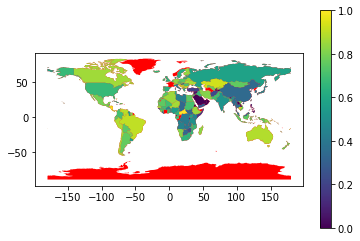

In [321]:
fig, ax = plt.subplots()
shape.plot(color="red", ax = ax)
df_geo.plot(column = "RATIO", legend = True, ax = ax)

Даже на этой маленькой карте видно, что на нашей карте, как минимум, нет Франции и Норвегии. А чего еще нет?

In [322]:
df_geo = shape[["ISO_N3", "geometry", "NAME", "ADMIN"]]
df_geo.loc[:, "ISO"] = pd.to_numeric(df_geo["ISO_N3"]) #Делаем столбец ISO одинаковым для обоих датасетов
df_geo = df_geo.drop(labels = "ISO_N3", axis = 1)
for iso in list(set(df_geo["ISO"]) - set(df_sum["ISO"])):
    print(df_geo[df_geo["ISO"] == iso][["ISO", "NAME"]])

    ISO           NAME
60  384  Côte d'Ivoire
    ISO     NAME
89  548  Vanuatu
    ISO                    NAME
23  260  Fr. S. Antarctic Lands
     ISO        NAME
159   10  Antarctica
    ISO      NAME
73  748  eSwatini
    ISO       NAME
22  304  Greenland
    ISO   NAME
67  178  Congo
    ISO         NAME
24  626  Timor-Leste
    ISO         NAME
45  630  Puerto Rico
    ISO         NAME
95  408  North Korea
     ISO          NAME
106  795  Turkmenistan
   ISO       NAME
2  732  W. Sahara
     ISO        NAME
21   -99      Norway
43   -99      France
160  -99   N. Cyprus
167  -99  Somaliland
174  -99      Kosovo


Много где не совпало, и хоть бОльшая часть территорий - это какие - то сомнительные острова без наблюдений, попытаемся соединить всё

In [323]:
df_geo = shape[["ISO_N3", "geometry", "NAME", "ADMIN"]]
df_geo.loc[:, "ISO"] = pd.to_numeric(df_geo["ISO_N3"]) #Делаем столбец ISO одинаковым для обоих датасетов
df_geo = df_geo.drop(labels = "ISO_N3", axis = 1)

#стыковка ISO
join_dict = df_sum.set_index("COUNTRY")["ISO"].to_dict()
iso_unstacked = list(set(df_geo["ISO"]) - set(df_sum["ISO"]))

for iso in iso_unstacked:
    mask = df_geo["ISO"] == iso
    df_geo.loc[mask, "ISO"] = df_geo.loc[mask, "NAME"].map(join_dict).values

In [324]:
df_geo.isna().sum()

geometry     0
NAME         0
ADMIN        0
ISO         14
dtype: int64

Потеряли 14 стран, но по ним не было наблюдений. <br>Соединим снова

In [325]:
df_geo = df_geo.merge(df_sum, on="ISO")
df_geo

,geometry,NAME,ADMIN,ISO,COUNTRY,UNORGANIZED,DISORDERS,RATIO
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji,Fiji,242.0,Fiji,6,7,0.857143
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,United Republic of Tanzania,834.0,Tanzania,1,2,0.500000
2,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,Canada,124.0,Canada,626,730,0.857534
3,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States of America,United States of America,840.0,United States,5214,7736,0.673992
4,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",Kazakhstan,Kazakhstan,398.0,Kazakhstan,247,266,0.928571
...,...,...,...,...,...,...,...,...
158,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",Serbia,Republic of Serbia,688.0,Serbia,128,147,0.870748
159,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",Montenegro,Montenegro,499.0,Montenegro,42,44,0.954545
160,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",Kosovo,Kosovo,0.0,Kosovo,37,43,0.860465
161,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",Trinidad and Tobago,Trinidad and Tobago,780.0,Trinidad and Tobago,22,40,0.550000


Посмотрим на карту снова

<AxesSubplot:>

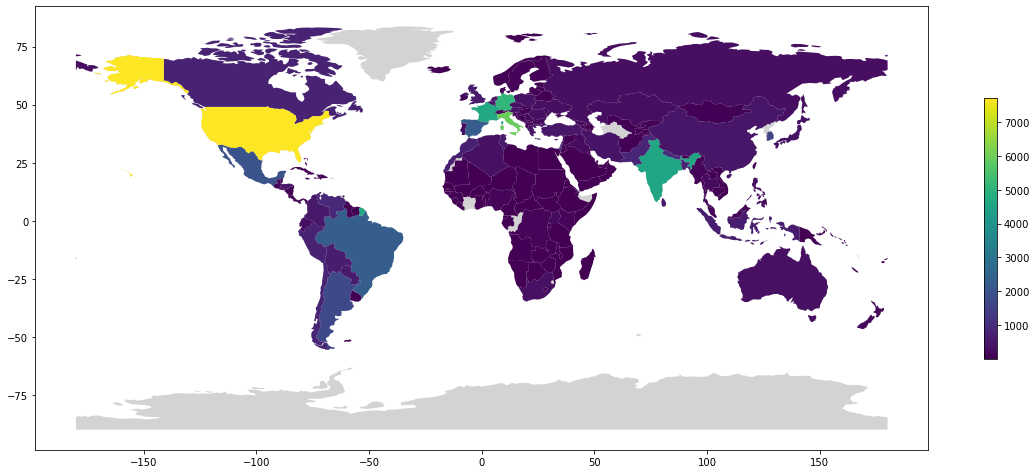

In [326]:
fig, ax = plt.subplots(figsize=(20, 16))
shape.plot(ax=ax, color="lightgrey")
df_geo.plot(column = "DISORDERS", legend = True, legend_kwds={'shrink': 0.3}, ax=ax)

Всё работает! Вся эта работа вела к одному очевидному финалу - огромой жуткой функции, в которую можно будет подавать два датасета (с данными и с географией) и кучу списков параметров, которая будет сама делать датасет для визуализации.

Ну и будет убрана в отдельный модуль, конечно же.

In [327]:
def geo_join_pro(dataset_name_excel, mapshape_file,
                 dataset_target, #
                 dataset_features_cum, #Кумулятивные признаки ("Всего заболело")
                 dataset_features_stat, #Статистические признаки ("ВВП на душу населения")
                 dataset_features_dyn, #Признаки наблюдений ("UNORGANIZED", "FATALITIES")
                 dataset_features_dyn_ratio #Тоже признаки наблюдений, но для расчета долей (только для bool!)
                ):
    
    df = pd.read_excel(dataset_name_excel) #датасет
    df.set_index(df.columns[0], inplace = True)
    df['EVENT_DATE'] = pd.to_datetime(df['EVENT_DATE'])
    
    df_sum = df[[dataset_target, "ISO", "COUNTRY"]].groupby(by = ["ISO", "COUNTRY"]).sum()
    
    for feature in dataset_features_cum:
        df_sum[feature] = df[[feature, "ISO", "COUNTRY"]].groupby(by = ["ISO", "COUNTRY"]).last().fillna(method="ffill")
        
    for feature in dataset_features_stat:
        df_sum[feature] = df[[feature, "ISO", "COUNTRY"]].groupby(by = ["ISO", "COUNTRY"]).mean()
    
    for feature in dataset_features_dyn:
        df_sum[feature] = df[[feature, "ISO", "COUNTRY"]].groupby(by = ["ISO", "COUNTRY"]).sum()
    
    for feature in dataset_features_dyn_ratio:
        df_sum[feature + "_RATIO"] = df[[feature, "ISO", "COUNTRY"]].groupby(by = ["ISO", "COUNTRY"]).sum() / df[[feature, "ISO", "COUNTRY"]].groupby(by = ["ISO", "COUNTRY"]).count()
    
    df_sum.reset_index(inplace = True)
    df_sum["ISO"].astype("int64")    
    
    shape = gpd.read_file(mapshape_file) #файл карты
    df_geo = shape[["ISO_N3", "geometry", "NAME"]]
    df_geo.loc[:, "ISO"] = pd.to_numeric(df_geo["ISO_N3"]) #Делаем столбец ISO одинаковым для обоих датасетов
    df_geo = df_geo.drop(labels = "ISO_N3", axis = 1)
    
    #стыковка ISO
    join_dict = df_sum.set_index("COUNTRY")["ISO"].to_dict()
    iso_unstacked = list(set(df_geo["ISO"]) - set(df_sum["ISO"]))

    for iso in iso_unstacked:
        mask = df_geo["ISO"] == iso
        df_geo.loc[mask, "ISO"] = df_geo.loc[mask, "NAME"].map(join_dict).values
        
    df_geo = df_geo.merge(df_sum, on="ISO")
    return df_geo

Ну и протестируем её

In [328]:
dset = "datasets/disorders.xlsx"
mapfile = "mapshape/ne_110m_admin_0_countries.shp"
target = "UNORGANIZED"
ds_cum = ["total_cases", 'total_cases_per_million', "total_deaths", 'total_deaths_per_million']
ds_stat = ['reproduction_rate',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index']
ds_dyn = ['FATALITIES']
ds_dyn_ratio = ['UNORGANIZED', 'FATALITIES']

df_geo = geo_join_pro(dset, mapfile, target, ds_cum, ds_stat, ds_dyn, ds_dyn_ratio)
df_geo

,geometry,NAME,ISO,COUNTRY,UNORGANIZED,total_cases,total_cases_per_million,total_deaths,total_deaths_per_million,reproduction_rate,...,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,female_smokers,hospital_beds_per_thousand,life_expectancy,human_development_index,FATALITIES,UNORGANIZED_RATIO,FATALITIES_RATIO
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji,242.0,Fiji,6,52532.0,58181.480,697.0,771.958,1.512857,...,8702.975,412.820,14.49,10.2,2.300,67.44,0.743,0,0.857143,0.000000
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,834.0,Tanzania,1,480.0,7.805,16.0,0.260,0.240000,...,2683.304,217.288,5.75,3.3,0.700,65.46,0.529,0,0.500000,0.000000
2,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,124.0,Canada,626,3334009.0,87580.556,36998.0,971.895,0.955831,...,44017.591,105.599,7.37,12.0,2.500,82.43,0.929,0,0.857534,0.000000
3,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States of America,840.0,United States,5214,79265726.0,238095.936,958437.0,2878.923,1.043706,...,54225.446,151.089,10.79,19.1,2.770,78.86,0.926,5,0.673992,0.000646
4,"POLYGON ((87.35997 49.21498, 86.59878 48.54918...",Kazakhstan,398.0,Kazakhstan,247,1389288.0,73139.830,18906.0,995.317,1.118893,...,24055.588,466.792,7.11,7.0,6.700,73.60,0.825,0,0.928571,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",Serbia,688.0,Serbia,128,1913861.0,278519.670,15280.0,2223.662,1.127075,...,14048.881,439.415,10.08,37.7,5.609,76.00,0.806,0,0.870748,0.000000
159,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",Montenegro,499.0,Montenegro,42,223774.0,356299.090,2610.0,4155.713,1.096818,...,16409.288,387.305,10.08,44.0,3.861,76.88,0.829,0,0.954545,0.000000
160,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",Kosovo,0.0,Kosovo,37,161227.0,90469.470,2988.0,1676.659,0.925278,...,9795.834,NaN,NaN,NaN,NaN,NaN,NaN,0,0.860465,0.000000
161,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",Trinidad and Tobago,780.0,Trinidad and Tobago,22,126502.0,90141.331,3608.0,2570.947,0.990278,...,28763.071,228.467,10.97,NaN,3.000,73.51,0.796,0,0.550000,0.000000


In [329]:
df_geo.columns

Index(['geometry', 'NAME', 'ISO', 'COUNTRY', 'UNORGANIZED', 'total_cases',
       'total_cases_per_million', 'total_deaths', 'total_deaths_per_million',
       'reproduction_rate', 'stringency_index', 'population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence',
       'female_smokers', 'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'FATALITIES', 'UNORGANIZED_RATIO',
       'FATALITIES_RATIO'],
      dtype='object')

KeyError: 'UNORGANIZEDRATIO'

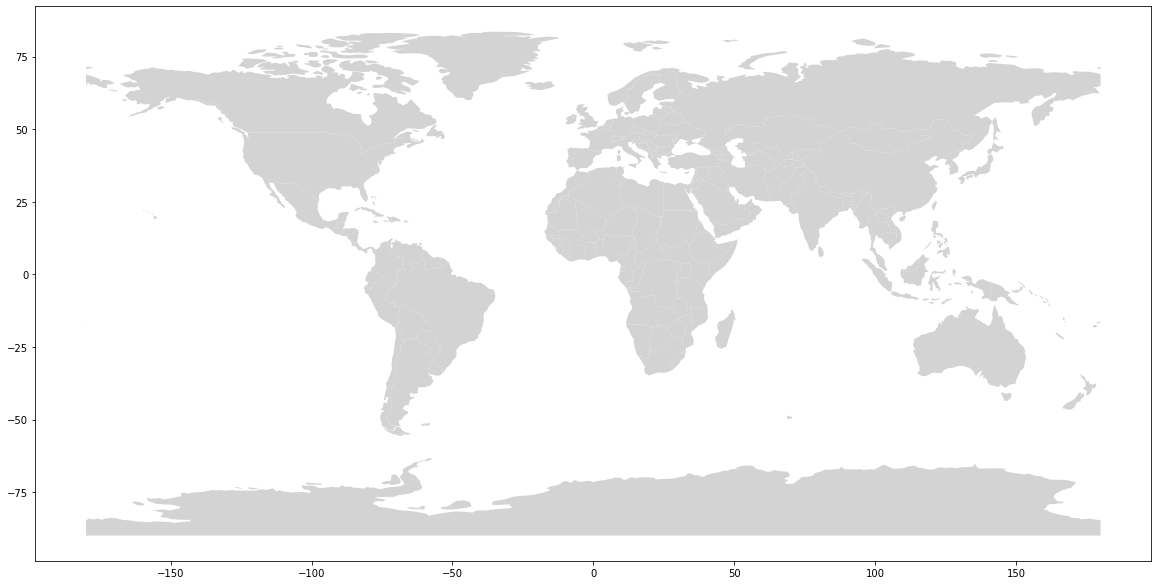

In [330]:
fig, ax = plt.subplots(figsize=(20, 16))
shape.plot(ax=ax, color="lightgrey")
df_geo.plot(column = 'UNORGANIZEDRATIO', legend = True, legend_kwds={'shrink': 0.3}, ax=ax)

Всё работает. Полноценные визуализации с пояснениями можно найти в тетради "2 - Visualisation.ipynb".


Это первая версия огромной страшной функции
def geo_join(dataset_name_excel, mapshape_file):
    
    
    df = pd.read_excel(dataset_name_excel) #датасет
    df.set_index(df.columns[0], inplace = True)
    df['EVENT_DATE'] = pd.to_datetime(df['EVENT_DATE'])
    
    df_sum = df[["UNORGANIZED", "ISO", "COUNTRY"]].groupby(by = ["ISO", "COUNTRY"]).sum()
    df_sum["DISORDERS"] = df[["UNORGANIZED", "ISO", "COUNTRY"]].groupby(by = ["ISO", "COUNTRY"]).count()
    df_sum["RATIO"] = df_sum["UNORGANIZED"] / df_sum["DISORDERS"]
    df_sum.reset_index(inplace = True)
    df_sum["ISO"].astype("int64")    
    
    shape = gpd.read_file(mapshape_file) #файл карты
    df_geo = shape[["ISO_N3", "geometry", "NAME"]]
    df_geo.loc[:, "ISO"] = pd.to_numeric(df_geo["ISO_N3"]) #Делаем столбец ISO одинаковым для обоих датасетов
    df_geo = df_geo.drop(labels = "ISO_N3", axis = 1)
    
    #стыковка ISO
    join_dict = df_sum.set_index("COUNTRY")["ISO"].to_dict()
    iso_unstacked = list(set(df_geo["ISO"]) - set(df_sum["ISO"]))

    for iso in iso_unstacked:
        mask = df_geo["ISO"] == iso
        df_geo.loc[mask, "ISO"] = df_geo.loc[mask, "NAME"].map(join_dict).values
        
    df_geo = df_geo.merge(df_sum, on="ISO")
    return df_geo